In [1]:
# -------------------- imports & setup --------------------
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import torch
import os
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-22 22:26:26.223444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 22:26:26.230272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750602386.239494   68796 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750602386.242387   68796 cuda_blas.cc:1407

In [2]:
# -------------------- data --------------------
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

X_full = train_df["Review Comment"]
y_full = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.10, random_state=SEED, stratify=y_full
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [3]:
# -------------------- sentence-transformer embeddings --------------------
device   = "cuda" if torch.cuda.is_available() else "cpu"   # put encoder on GPU
embedder = SentenceTransformer("all-MiniLM-L6-v2", device=device)

def embed(texts):
    """Returns float32 numpy array (CatBoost prefers float32)."""
    return embedder.encode(
        texts.tolist(), show_progress_bar=True, batch_size=64, device=device
    ).astype(np.float32)

Xtr_emb  = embed(X_train)
Xval_emb = embed(X_val)

Batches: 100%|██████████| 2/2 [00:00<00:00, 34.17it/s]


In [4]:
# -------------------- CatBoost on GPU --------------------
base_cb = CatBoostClassifier(
    loss_function="MultiClass",
    random_seed=SEED,
    verbose=False,          # silence training logs
    task_type="GPU",        # crucial—forces training on GPU
    devices="0",
    thread_count=-1,              
)

param_grid = {
    "iterations":     [300, 600],
    "learning_rate":  [0.05, 0.1],
    "depth":          [6, 8, 10],
    "l2_leaf_reg":    [1, 3, 5]
}

search = GridSearchCV(
    base_cb, param_grid,
    cv=5, n_jobs=1, scoring="accuracy", verbose=1
)
search.fit(Xtr_emb, y_train)

print("Best CV-accuracy :", search.best_score_)
print("Best params      :", search.best_params_)
best_cb = search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Best CV-accuracy : 0.5650199600798402
Best params      : {'depth': 6, 'iterations': 600, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [5]:
# -------------------- retrain on full training set --------------------
X_full_emb = embed(X_full)
best_cb.fit(X_full_emb, y_full)

Batches: 100%|██████████| 15/15 [00:00<00:00, 76.49it/s]


Batches: 100%|██████████| 4/4 [00:00<00:00, 44.96it/s]


Test accuracy: 0.5769

              precision    recall  f1-score   support

      delete       0.61      0.55      0.58        78
      insert       0.57      0.60      0.59        81
     replace       0.55      0.57      0.56        75

    accuracy                           0.58       234
   macro avg       0.58      0.58      0.58       234
weighted avg       0.58      0.58      0.58       234



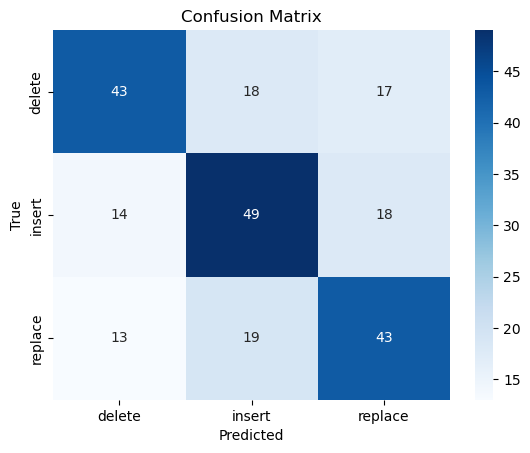

In [6]:
# -------------------- test evaluation --------------------
X_test    = test_df["Review Comment"].astype(str)
y_test    = test_df["Expected Operation by Developer"]
Xtest_emb = embed(X_test)

y_pred = best_cb.predict(Xtest_emb)
acc    = accuracy_score(y_test, y_pred)
print(f"\nTest accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_full))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_full),
            yticklabels=np.unique(y_full))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()

In [7]:
# -------------------- feature importance (embedding dims) --------------------
imp = best_cb.get_feature_importance(type="FeatureImportance")
top = np.argsort(imp)[-10:][::-1]
print("Top 10 embedding dimensions by importance:", top)


Top 10 embedding dimensions by importance: [319 376 286 261  11 151 317 149 382 201]
